<a href="https://colab.research.google.com/github/moutombi21/load-lstm/blob/main/Consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prédire la consommation énergétique future

## 1. EDA (Exploratory Data Analysis)

**Objectif** : Se familiariser avec le dataset et comprendre au maximum les différentes variables afin de définir une stratégie de modélisation. Que va-t-on faire avec nos données pour atteindre notre objectif ?

### Checklist de base (non exhaustive)

#### Analyse de la forme
- Identification de la target
- Nombre de lignes et de colonnes
- Types de variables
- Identification des valeurs manquantes

#### Analyse du fond
- Visualisation de la target (histogramme, boxplot)
- Compréhension des différentes variables (recherche documentaire, études en ligne)
- Visualisation des relations entre les features et la target (histogrammes, boxplots)
- Identification des outliers

---

## 2. Pre-processing

L'objectif est de prétraiter nos données pour les transformer en un format adapté au développement de modèles de machine learning et/ou de deep learning.

### Checklist de base (non exhaustive)
- Création du train set / test set
- Élimination des NaN : utilisation de méthodes comme `dropna()`, imputation ou suppression des colonnes « vides »
- Encodage : transformer chaque variable catégorielle en valeur numérique (via `.replace()`, `.map()`, etc.)
- Suppression des outliers néfastes au modèle
- Sélection de features : éliminer les variables sans variance (variance nulle, variables redondantes, etc.)
- Feature engineering : créer de nouvelles variables à partir de celles déjà existantes
- Feature scaling : normalisation des données (min-max scaling ou standard scaler)

---

## 3. Modélisation

L'objectif est de créer un modèle de machine learning, de l'entraîner, de l'évaluer et de l'améliorer en affinant la sélection des variables et en ajustant le pré-processing.

- Définir une fonction d'évaluation fiable et reproductible
- Entraîner différents modèles
- Optimiser les hyperparamètres
- Analyser les erreurs et revenir éventuellement au pre-processing / EDA pour réviser la stratégie
- Utiliser la courbe d'apprentissage (learning curve) pour orienter la prise de décision


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp, year, month, avg, sum, to_date, col

In [ ]:
spark = SparkSession.builder.appName('Consumption_Preprocessing').getOrCreate()

In [ ]:
data = pd.read_excel("/content/dataset_ods001.xlsx")

In [ ]:
data.head()

,Datetime,Resolution code,Total Load,Most recent forecast,Most recent P10,Most recent P90,Day-ahead 6PM forecast,Day-ahead 6PM P10,Day-ahead 6PM P90,Week-ahead forecast
0,2025-03-20T23:45:00+01:00,PT15M,NaN,9041-06-01 00:00:00,8638.29,9444.92,9041-06-01 00:00:00,8638.29,9444.92,9041-06-01 00:00:00
1,2025-03-20T23:30:00+01:00,PT15M,NaN,9124.52,8717.51,9531.53,9124.52,8717.51,9531.53,9124.52
2,2025-03-20T23:15:00+01:00,PT15M,NaN,9220-06-01 00:00:00,8808.79,9631.34,9220-06-01 00:00:00,8808.79,9631.34,9220-06-01 00:00:00
3,2025-03-20T23:00:00+01:00,PT15M,NaN,9348-09-01 00:00:00,8931.89,9765.92,9348-09-01 00:00:00,8931.89,9765.92,9348-09-01 00:00:00
4,2025-03-20T22:45:00+01:00,PT15M,NaN,9368.18,8961.59,9774.77,9368.18,8961.59,9774.77,9368.18


## 1. EDA (Exploratory Data Analysis)

**Objectif** :
- Comprendre du mieux possible nos données.
- Développer une première stratégie de modélisation.

### Checklist de base

#### Analyse de la forme
- Identification de la target : Total Load (Total de la consommation d'électricité en MégaWatt)
- Nombre de lignes et de colonnes : 358272 lignes et 10 colonnes
- Types de variables : quantitatives :

*   1 Variables Quantitative
*   1 Variable Qualitative : Variable temporelle (DateTime)


- Analyser les valeurs manquantes : Nous avons observé que le dataset est entier, il y a très peu voire pas du tout de valeurs manquantes. En revanche, `Total Load` a 20% de données NaN


In [ ]:
df = data.copy()

In [ ]:
df.shape

(358272, 10)

<Axes: >

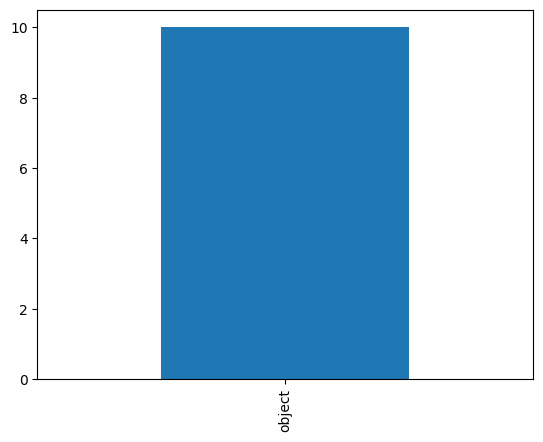

In [ ]:
# les types de variables
df.dtypes.value_counts().plot(kind='bar')

<Axes: >

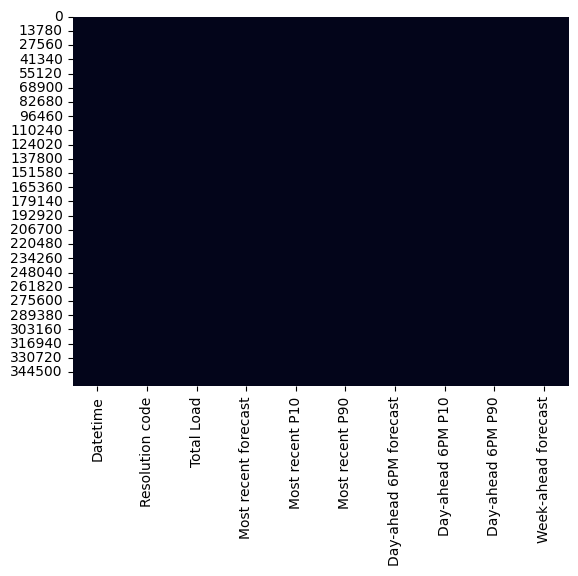

In [ ]:
# vérifier les valeurs manquantes
sns.heatmap(df.isna(), cbar=False)

In [ ]:
# mesurer le % de NaN
(df.isna().sum() / df.shape[0] * 100).sort_values(ascending=True)

,0
Datetime,0.000000
Resolution code,0.000000
Most recent forecast,0.000000
Most recent P10,0.000000
Day-ahead 6PM forecast,0.000000
Most recent P90,0.000000
Day-ahead 6PM P10,0.000000
Day-ahead 6PM P90,0.000000
Week-ahead forecast,0.053591
Total Load,0.211013


In [ ]:
# supprimer colonnes inutiles
df = df.drop(['Resolution code', 'Day-ahead 6PM forecast', 'Most recent P90','Day-ahead 6PM P10', 'Day-ahead 6PM P90', 'Most recent forecast', 'Most recent P10', 'Week-ahead forecast' ],  axis=1)


In [ ]:
df.head()

,Datetime,Total Load
0,2025-03-20T23:45:00+01:00,NaN
1,2025-03-20T23:30:00+01:00,NaN
2,2025-03-20T23:15:00+01:00,NaN
3,2025-03-20T23:00:00+01:00,NaN
4,2025-03-20T22:45:00+01:00,NaN


In [ ]:
df = df.dropna()

In [ ]:
df.head()

,Datetime,Total Load
749,2025-03-13T04:30:00+01:00,8320-04-01 00:00:00
750,2025-03-13T04:15:00+01:00,8484.95
751,2025-03-13T04:00:00+01:00,8433.36
752,2025-03-13T03:45:00+01:00,8381.24
753,2025-03-13T03:30:00+01:00,8340.94


#### Analyse du Fond
- Visualisation de la target : En déchiffrant la variable `Total Load` pour différente référence temporelle, nous
- Compréhension des différentes variables (recherche documentaire, études en ligne)
- Visualisation des relations entre les features et la target
- Identification des outliers

In [ ]:
df['Total Load'].value_counts()

,count
Total Load,
9339-09-01 00:00:00,8
8894-05-01 00:00:00,8
9808-04-01 00:00:00,8
9991-05-01 00:00:00,8
9937-01-01 00:00:00,8
...,...
8328.77,1
8389.37,1
9204.77,1


#### Variable quantitatives

In [ ]:
for col in df.select_dtypes(include='object').columns:
    print(f'{col : <50}, {df[col].unique()}')

Datetime                                          , ['2025-03-13T04:30:00+01:00' '2025-03-13T04:15:00+01:00'
 '2025-03-13T04:00:00+01:00' ... '2015-01-01T00:30:00+01:00'
 '2015-01-01T00:15:00+01:00' '2015-01-01T00:00:00+01:00']
Total Load                                        , [datetime.datetime(8320, 4, 1, 0, 0) '8484.95' '8433.36' ... '9821.78'
 '9952.87' '10142.19']


In [ ]:
# transformation des données de type datetime dans Total Load "i.e 8320, 4, 1, 0, 0 => 8320"
df['Total Load'] = df['Total Load'].apply(lambda x: str(x)[:4] if '-' in str(x) else x)

In [ ]:
df.head()

,Datetime,Total Load
749,2025-03-13T04:30:00+01:00,8320
750,2025-03-13T04:15:00+01:00,8484.95
751,2025-03-13T04:00:00+01:00,8433.36
752,2025-03-13T03:45:00+01:00,8381.24
753,2025-03-13T03:30:00+01:00,8340.94


## Distribution des données de consommation

In [ ]:
df['Total Load'] = pd.to_numeric(df['Total Load'], errors='coerce')

<ipython-input-21-d223183bea14>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Total Load'],shade=True, color="red")


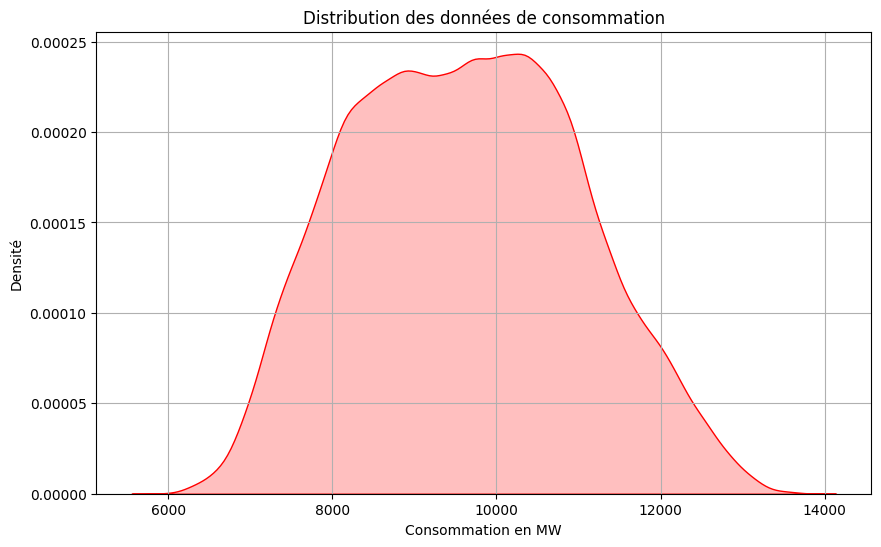

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(df['Total Load'],shade=True, color="red")
plt.title('Distribution des données de consommation')
plt.xlabel('Consommation en MW')
plt.ylabel('Densité')
plt.grid()
plt.show()

## Extraction des variables Year & Month depuis Datetime

In [ ]:
# conversion Pandas DataFrame vers PySpark DataFrame
spark_df = spark.createDataFrame(df)

# extraction de 'Year' et 'Month' depuis DateTime
spark_df = spark_df.withColumn("Year", year(spark_df["Datetime"]))
spark_df = spark_df.withColumn("Month", month(spark_df["Datetime"]))

In [ ]:
spark_df.show()

+--------------------+----------+----+-----+
|            Datetime|Total Load|Year|Month|
+--------------------+----------+----+-----+
|2025-03-13T04:30:...|    8320.0|2025|    3|
|2025-03-13T04:15:...|   8484.95|2025|    3|
|2025-03-13T04:00:...|   8433.36|2025|    3|
|2025-03-13T03:45:...|   8381.24|2025|    3|
|2025-03-13T03:30:...|   8340.94|2025|    3|
|2025-03-13T03:15:...|   8345.13|2025|    3|
|2025-03-13T03:00:...|   8358.91|2025|    3|
|2025-03-13T02:45:...|   8404.91|2025|    3|
|2025-03-13T02:30:...|   8494.59|2025|    3|
|2025-03-13T02:15:...|   8465.13|2025|    3|
|2025-03-13T02:00:...|   8489.26|2025|    3|
|2025-03-13T01:45:...|   8543.97|2025|    3|
|2025-03-13T01:30:...|   8590.42|2025|    3|
|2025-03-13T01:15:...|   8825.53|2025|    3|
|2025-03-13T01:00:...|   8845.69|2025|    3|
|2025-03-13T00:45:...|   8840.54|2025|    3|
|2025-03-13T00:30:...|   8909.25|2025|    3|
|2025-03-13T00:15:...|   8980.88|2025|    3|
|2025-03-13T00:00:...|   9126.94|2025|    3|
|2025-03-1

## Visualisation de la consommation moyenne par année.

In [ ]:
# calcul de la moyenne de consommation par an
ann_avg_load = spark_df.groupBy('Year').agg(avg('Total Load').alias("average_load"))

# conversion vers Pandas Dataframe
pd_ann_avg_load = ann_avg_load.toPandas()

In [ ]:
pd_ann_avg_load

,Year,average_load
0,2025,10213.039353
1,2023,9007.323279
2,2022,9329.687863
3,2020,9237.365802
4,2024,9218.023441
5,2021,9641.449335
6,2018,9987.127727
7,2015,10045.369239
8,2019,9697.372200
9,2016,9891.369598


In [ ]:
# sauvegarder les résultats du calcul
pd_ann_avg_load.to_excel('/content/average_year_load.xlsx', index=False)

In [ ]:
ann_avg_load.show()

+----+------------------+
|Year|      average_load|
+----+------------------+
|2025|10213.039353328433|
|2023| 9007.323279390268|
|2022| 9329.687862728215|
|2020| 9237.365802310862|
|2024| 9218.023440630604|
|2021| 9641.449334969599|
|2018| 9987.127726883456|
|2015|10045.369238869811|
|2019| 9697.372200342386|
|2016| 9891.369597563633|
|2017| 9969.757021689482|
+----+------------------+



In [ ]:
# filtre des années par ordre
pd_ann_avg_load = pd_ann_avg_load.sort_values('Year')

# affichage du df
pd_ann_avg_load

,Year,average_load
7,2015,10045.369239
9,2016,9891.369598
10,2017,9969.757022
6,2018,9987.127727
8,2019,9697.372200
3,2020,9237.365802
5,2021,9641.449335
2,2022,9329.687863
1,2023,9007.323279
4,2024,9218.023441


## Visualisation annuelle de la consomation  

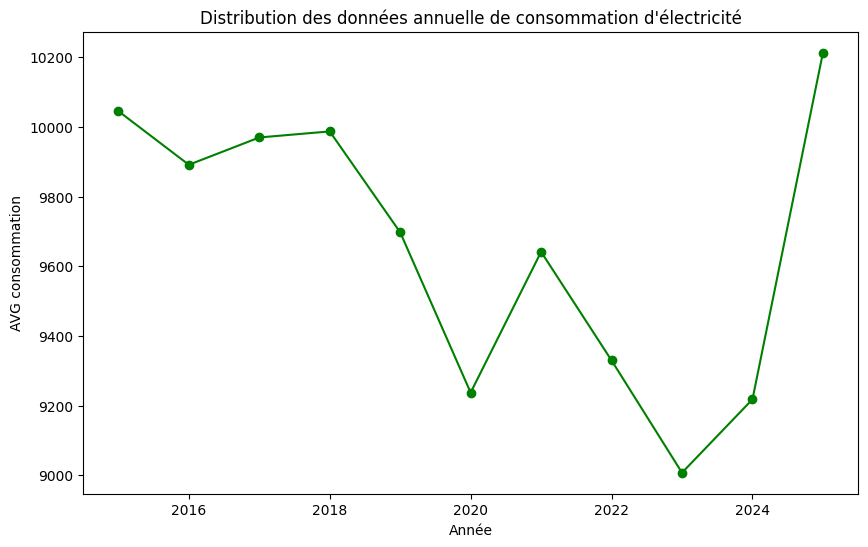

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(pd_ann_avg_load['Year'], pd_ann_avg_load['average_load'], marker='o', color='green')
plt.title('Distribution des données annuelle de consommation d\'électricité')
plt.xlabel('Année')
plt.ylabel('AVG consommation')
plt.show()


 - On observe une certaine fluctuation au fil des ans, avec des hausses et des baisses successives.

- On observe entre la période 2015-2017 un niveau relativement constant avec une légère baisse et quelques légère monté.

- Une baisse très marque entre la période 2018 et 2019 qui ce suit par un rebonds en 2021 puis une nouvelle baisse vers 2022-2023.

- Forte hausse en 2024 et 2025. La courbe montre brusquement, atteignant voire même dpassant les niveau de consommation initiaux.


### Visualisation mensuelle de consommation pou chaque année

In [ ]:
# aggregattion des données par année et mois
df_monthly_load = spark_df.groupBy('Year', 'Month') \
.agg(
    sum('Total Load').alias('Total Load'), # somme consommation
    avg('Total Load').alias("Average Load") # moyenne consommation
) \
.orderBy('Year', 'Month')

In [ ]:
df_monthly_load.show()

+----+-----+--------------------+------------------+
|Year|Month|          Total Load|      Average Load|
+----+-----+--------------------+------------------+
|2015|    1| 3.355765057000002E7| 11276.09226142474|
|2015|    2| 3.050644042999993E7|11349.122183779735|
|2015|    3| 3.187084836999997E7|10723.704027590838|
|2015|    4| 2.902572317000006E7|10078.376100694466|
|2015|    5|2.8310921630000014E7| 9513.078504704306|
|2015|    6|2.7619186000000067E7| 9589.995138888913|
|2015|    7|2.7128762779999975E7| 9115.847708333325|
|2015|    8|2.7040558379999932E7| 9086.209133064493|
|2015|    9| 2.794381693000002E7| 9702.714211805562|
|2015|   10|2.9692291730000056E7| 9963.856285234919|
|2015|   11|2.9308909239999987E7|10176.704597222219|
|2015|   12| 2.998462890000002E7| 10075.48014112904|
|2016|    1|       3.177744782E7|10677.905853494623|
|2016|    2|2.9996854939999968E7|10774.732377873552|
|2016|    3| 3.090945929999997E7|10400.221837146693|
|2016|    4|2.8383766730000027E7| 9855.4745590

### Année incomplète au niveau des mois

In [ ]:
df_monthly_load.filter(df_monthly_load['Year']==2025).show()

+----+-----+--------------------+------------------+
|Year|Month|          Total Load|      Average Load|
+----+-----+--------------------+------------------+
|2025|    1| 3.103685500000004E7|10429.050739247326|
|2025|    2|2.7788418510000072E7|10337.953314732169|
|2025|    3|1.0980850470000025E7| 9377.327472245965|
+----+-----+--------------------+------------------+



L' ensemble des mois de chaque années sont complet hormis le mois de l'année 2025 qui ne compte que 3 mois (logique car l'année est en cours a l'ecriture de ce notebook.).

In [ ]:
# conversion en Panda df
pd_monthly_load = df_monthly_load.toPandas()

# sauvegarde des resultats
pd_monthly_load.to_excel('/content/monthly_load_per_year.xlsx', index=False)

In [ ]:
pd_monthly_load

,Year,Month,Total Load,Average Load
0,2015,1,33557650.57,11276.092261
1,2015,2,30506440.43,11349.122184
2,2015,3,31870848.37,10723.704028
3,2015,4,29025723.17,10078.376101
4,2015,5,28310921.63,9513.078505
...,...,...,...,...
118,2024,11,27991029.70,9719.107535
119,2024,12,28874118.43,9702.324741
120,2025,1,31036855.00,10429.050739
121,2025,2,27788418.51,10337.953315


### Visualisation mensuelle de la conssomation pour chaque année du dataset

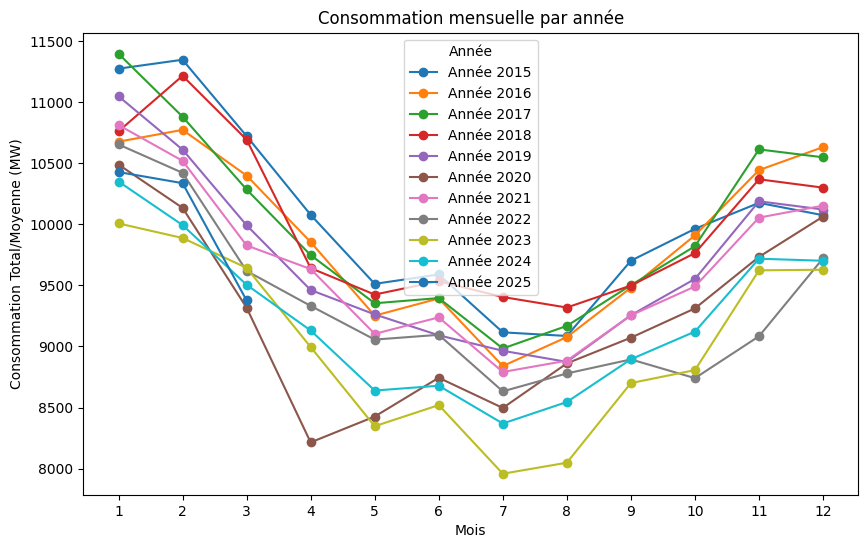

In [ ]:
# préparation des données pour la visualisation
years = pd_monthly_load['Year'].unique() #liste années

plt.figure(figsize=(10,6))

# parcourir chaque année
for yr in years:
  #filtratge
    yr_data = pd_monthly_load[pd_monthly_load['Year'] == yr]
    # plot pour l'année
    plt.plot(yr_data['Month'], yr_data['Average Load'], marker='o', label=f'Année {yr}')

plt.title('Consommation mensuelle par année')
plt.xlabel('Mois')
plt.ylabel('Consommation Total/Moyenne (MW)')
plt.xticks(range(1, 13)) # de 1 -> 12
plt.legend(title='Année')
plt.show()

Nous remques un pic de consommations sur le les mois d'hiver (janvier, février, voire décembre) et un creux sur les mois d'été (juin, juillet et aoùt).

Cette saisonalité est cohérente avec le fait que le chauffage et l'éclairage augmentent  la consommastion en hiver, tandis que la consommation baisse en été (en l'absence de climatisation massive, ou du moins présense que le chauffage).

Des différences de niveau de consommation selon les années, suggérant des facteurs supplémentaires (économiques, démographiques, politiques énergétiques, etc.).

On observe que l'année 2025 est incomplète.

### Visualisation de la consommation globale par saisons (Hiver: Décembre -> Mars, Primptemps : Mars -> Juin , été : Juin -> septembre, Automne : septembre -> Decembre)

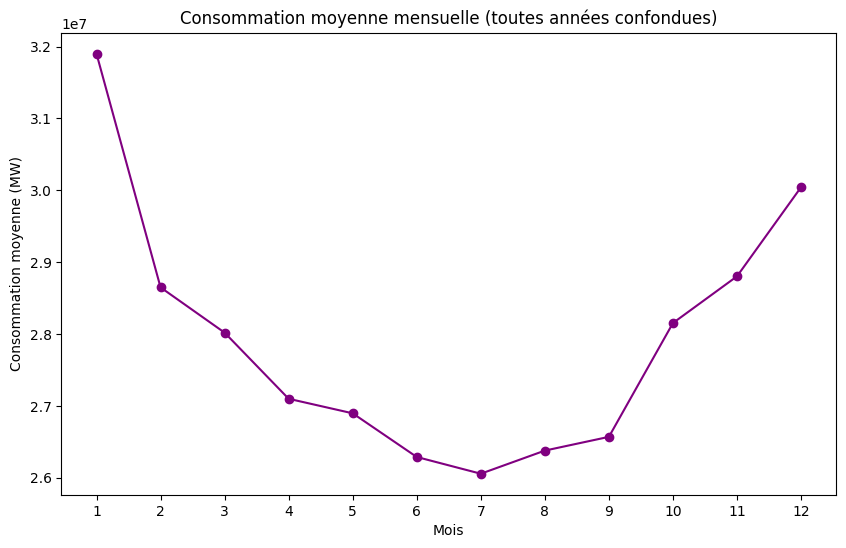

In [ ]:
df_avg_monthly = df_monthly_load.groupBy('Month') \
.agg(avg('Total Load').alias('Average Monthly Load')) \
.orderBy('Month').toPandas()

plt.figure(figsize=(10,6))
plt.plot(df_avg_monthly['Month'], df_avg_monthly['Average Monthly Load'], marker='o', color='purple')
plt.title('Consommation moyenne mensuelle (toutes années confondues)')
plt.xlabel('Mois')
plt.ylabel('Consommation moyenne (MW)')
plt.xticks(range(1, 13))
plt.show()

On observe que les mois hivernaux atteignetn des pic, notamment les mois 12, 1 et 2. On oberse également que la tendance comment a être élévé à partir des mois 10, 11.

Durant les mois 4 à 8, on observe une stabilisation en consommations. Les moyennes de consommations sont plus faible

## Consommation hebdomadaire/heure de la journée.

In [ ]:
df_hours_day_of_week = df.copy()
df_hours_day_of_week

,Datetime,Total Load
749,2025-03-13T04:30:00+01:00,8320.00
750,2025-03-13T04:15:00+01:00,8484.95
751,2025-03-13T04:00:00+01:00,8433.36
752,2025-03-13T03:45:00+01:00,8381.24
753,2025-03-13T03:30:00+01:00,8340.94
...,...,...
358267,2015-01-01T01:00:00+01:00,9755.00
358268,2015-01-01T00:45:00+01:00,9821.78
358269,2015-01-01T00:30:00+01:00,9952.87
358270,2015-01-01T00:15:00+01:00,10051.28


In [ ]:
# conversion en datetime et gestion des erreurs
df_hours_day_of_week['Datetime'] = pd.to_datetime(
    df_hours_day_of_week['Datetime'],
    errors='coerce',
    utc=True
)

# supprission de lignes invalides
df_hours_day_of_week.dropna(subset=['Datetime'], inplace=True)

# retirer les fuseau horaires.
df_hours_day_of_week['Datetime'] = df_hours_day_of_week['Datetime'].dt.tz_convert(None)

# extraction de jour de la semaine et heure
df_hours_day_of_week['DayOfTheWeek'] = df_hours_day_of_week['Datetime'].dt.dayofweek
df_hours_day_of_week['HourOfDay'] = df_hours_day_of_week['Datetime'].dt.hour

print(df_hours_day_of_week.columns)

Index(['Datetime', 'Total Load', 'DayOfTheWeek', 'HourOfDay'], dtype='object')


In [ ]:
df_hours_day_of_week

,Datetime,Total Load,DayOfTheWeek,HourOfDay
749,2025-03-13 03:30:00,8320.00,3,3
750,2025-03-13 03:15:00,8484.95,3,3
751,2025-03-13 03:00:00,8433.36,3,3
752,2025-03-13 02:45:00,8381.24,3,2
753,2025-03-13 02:30:00,8340.94,3,2
...,...,...,...,...
358267,2015-01-01 00:00:00,9755.00,3,0
358268,2014-12-31 23:45:00,9821.78,2,23
358269,2014-12-31 23:30:00,9952.87,2,23
358270,2014-12-31 23:15:00,10051.28,2,23


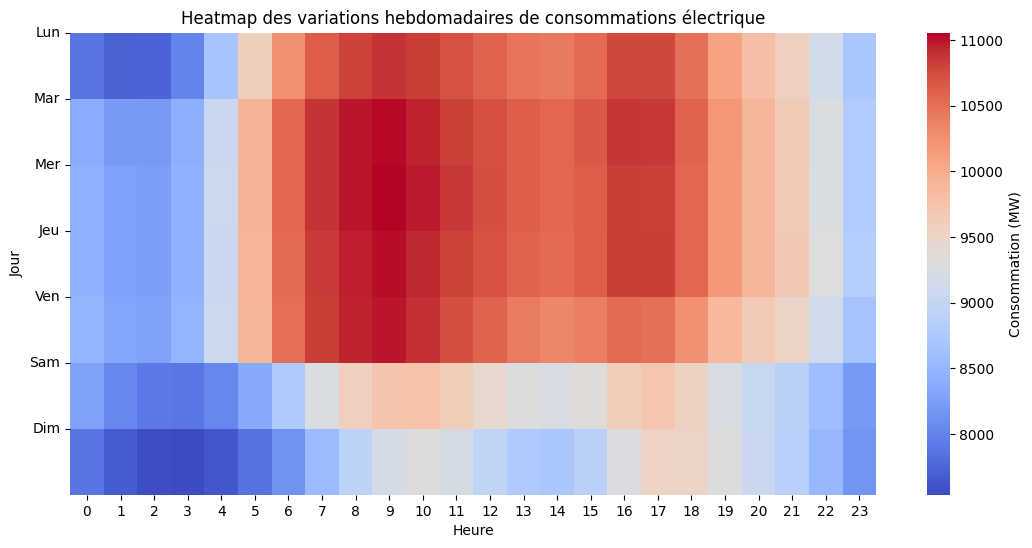

In [ ]:
# création de la heatmap
heatmap_data = df_hours_day_of_week.groupby(['DayOfTheWeek', 'HourOfDay'])['Total Load'].mean().unstack()

plt.figure(figsize=(13,6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=False, fmt='.0f', cbar_kws={'label': 'Consommation (MW)'})
plt.title('Heatmap des variations hebdomadaires de consommations électrique')
plt.xlabel('Heure')
plt.ylabel('Jour')
plt.yticks(range(7), ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim'], rotation=0)
plt.show()

La consommation énergetique atteint son minimun entre 22h et 4h du matin. Durant cette période, l'activité humaine est réduite (moins d'appareils électroménagers en marches, bureau et industries fermés.)

A partir de 5h voire plus tot(4h), consommation comment à augmenter rapidement. Cela corresponds à la reprise des activités humaines: réveil des ménages, mise en marches des appareil, débuts des activités professionnelles.

La consommation atteint ses pics entre 7h et 10h. Cela reflète une activité domestique important (éclairage,chauffage, etc. )

## Consommation Journalière

In [ ]:
# conversion vers Spark dataframe
spark_df1 = spark.createDataFrame(df)

df_daily_load = spark_df1.withColumn('Date', to_date('Datetime'))

df_daily_load_sum = df_daily_load.groupBy('Date').agg(sum('Total Load').alias('Daily Total Load')).orderBy('Date')

df_daily_load_sum.show()

+----------+------------------+
|      Date|  Daily Total Load|
+----------+------------------+
|2015-01-01|         874540.49|
|2015-01-02| 956299.8800000001|
|2015-01-03| 975790.3900000002|
|2015-01-04| 952406.5999999994|
|2015-01-05|        1111304.43|
|2015-01-06|1161558.5199999996|
|2015-01-07|1146576.7699999998|
|2015-01-08|        1148466.81|
|2015-01-09|1118710.1499999997|
|2015-01-10| 999386.7300000001|
|2015-01-11| 971177.5000000003|
|2015-01-12|        1102102.11|
|2015-01-13|         1110093.8|
|2015-01-14|1127792.3299999998|
|2015-01-15|        1125507.98|
|2015-01-16|1112378.0000000002|
|2015-01-17|1026343.5900000001|
|2015-01-18| 995162.6999999998|
|2015-01-19|1142033.0999999999|
|2015-01-20|1163919.4900000002|
+----------+------------------+
only showing top 20 rows



In [ ]:
# conversion vers Pandas dataframe
pd_daily_load_sum = df_daily_load_sum.orderBy('Date').toPandas()

pd_daily_load_sum

,Date,Daily Total Load
0,2015-01-01,874540.49
1,2015-01-02,956299.88
2,2015-01-03,975790.39
3,2015-01-04,952406.60
4,2015-01-05,1111304.43
...,...,...
3720,2025-03-09,786340.90
3721,2025-03-10,896971.84
3722,2025-03-11,944125.05
3723,2025-03-12,947175.47


In [ ]:
# sauvegarde des résultats
pd_daily_load_sum.to_excel('/content/daily_load.xlsx', index=False)

## Vérification des doublons

In [ ]:
from pyspark.sql.functions import count
from scipy.stats import zscore

In [ ]:
# grouper par date et compter
dups = df_daily_load_sum.groupBy("Date").agg(count('*').alias("count"))

#filtrer les dates qui apparaissent plus d'une fois
dups = dups.filter(dups["count"] > 1)

dups.show()

+----+-----+
|Date|count|
+----+-----+
+----+-----+



## Vérification des outliers

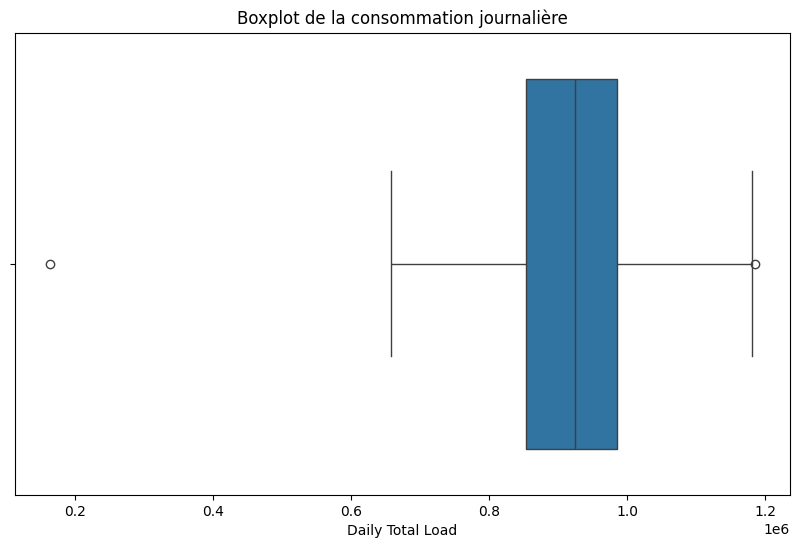

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x=pd_daily_load_sum['Daily Total Load'])
plt.title('Boxplot de la consommation journalière')
plt.show()

La majeure partie des valeurs de consommation journalière se situe entre environ 0.6 × 10^6 MW et 1.1 × 10^6 MW.

La médiane semble se situer autour de 0.9 × 10^6 MW.

Il y a quelques journées avec une consommation anormalement basse (autour de 0.2 × 10^6 MW) et d’autres anormalement hautes (autour de 1.2 × 10^6 MW).

In [ ]:
pd_daily_load_sum['z_score'] = zscore(pd_daily_load_sum['Daily Total Load'])
outliers = pd_daily_load_sum[(pd_daily_load_sum['z_score'].abs() > 3)]
print('Nombre de valeurs aberrantes détectées :', len(outliers))

Nombre de valeurs aberrantes détectées : 1


In [ ]:
outliers

,Date,Daily Total Load,z_score
3724,2025-03-13,163181.64,-7.746856


In [ ]:
# vers tableau numpy
np_outliers = outliers['Daily Total Load'].to_numpy()
np_outliers

array([163181.64])

## Prétraitement des données (Features Engineering, Encodage, Standardization, etc.)

- L'objectif est de prétraiter nos données pour les transformer en un format adapté au développement de modèles de machine learning et/ou de deep learning pour réussir à bien prévoir la consommation future.

### Vérification de la linéarité des données.

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=11 observations were given.
  return hypotest_fun_in(*args, **kwds)


                                OLS Regression Results                               
Dep. Variable:     Average annual Total Load   R-squared:                       0.737
Model:                                   OLS   Adj. R-squared:                  0.708
Method:                        Least Squares   F-statistic:                     25.20
Date:                       Sun, 16 Mar 2025   Prob (F-statistic):           0.000719
Time:                               20:18:22   Log-Likelihood:                -166.05
No. Observations:                         11   AIC:                             336.1
Df Residuals:                              9   BIC:                             336.9
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

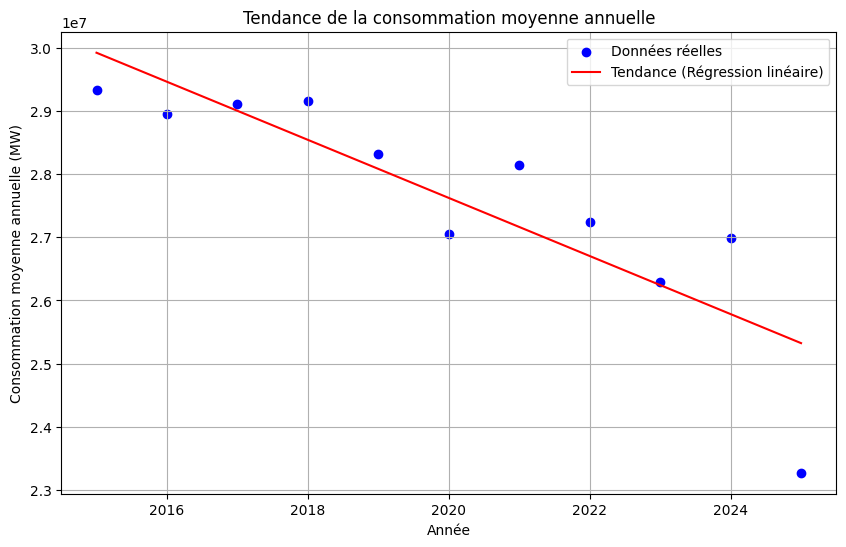

In [ ]:
import statsmodels.api as sm

df_ann = df_monthly_load.groupBy('Year') \
.agg(avg('Total Load').alias('Average annual Total Load'))\
.orderBy('Year').toPandas()

X = df_ann['Year']
y =df_ann['Average annual Total Load']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

# plot
plt.figure(figsize=(10, 6))
plt.scatter(df_ann['Year'], df_ann['Average annual Total Load'], color='blue', label='Données réelles')
plt.plot(df_ann['Year'], model.predict(X), color='red', label='Tendance (Régression linéaire)')
plt.title('Tendance de la consommation moyenne annuelle')
plt.xlabel('Année')
plt.ylabel('Consommation moyenne annuelle (MW)')
plt.legend()
plt.grid(True)
plt.show()


Tendance globale à la baisse : La droite de régression descendante indique qu’entre 2015 et 2025, la consommation moyenne annuelle diminue globalement.

### Importantion des données herdomandaires

In [ ]:
from pyspark.sql.functions import col, asc

In [ ]:
#df1 = pd.read_excel("/content/daily_load.xlsx")
df1 = df_daily_load_sum.orderBy(col('Date').asc())
df1.show()

+----------+------------------+
|      Date|  Daily Total Load|
+----------+------------------+
|2015-01-01|         874540.49|
|2015-01-02| 956299.8800000001|
|2015-01-03| 975790.3900000002|
|2015-01-04| 952406.5999999994|
|2015-01-05|        1111304.43|
|2015-01-06|1161558.5199999996|
|2015-01-07|1146576.7699999998|
|2015-01-08|        1148466.81|
|2015-01-09|1118710.1499999997|
|2015-01-10| 999386.7300000001|
|2015-01-11| 971177.5000000003|
|2015-01-12|        1102102.11|
|2015-01-13|         1110093.8|
|2015-01-14|1127792.3299999998|
|2015-01-15|        1125507.98|
|2015-01-16|1112378.0000000002|
|2015-01-17|1026343.5900000001|
|2015-01-18| 995162.6999999998|
|2015-01-19|1142033.0999999999|
|2015-01-20|1163919.4900000002|
+----------+------------------+
only showing top 20 rows



### Remplacer les valeurs aberrentes (outliers) avec la moyenne

In [ ]:
from pyspark.sql import functions as F

In [ ]:
# cacul de la moyenne de la colonne Daily Total Load
mean_value = df1.select(F.mean('Daily Total Load')).collect()[0][0]

# remplacement des valeurs aberrantes spécifiques par la moyenne
# definition de la seule valeur aberrante trouve dans l'EDA
detected_outliers = np_outliers.tolist()

# remplacement de la valeur par la moyenne
df1 = df1.withColumn('Daily Total Load',
                     F.when(F.col('Daily Total Load').isin(detected_outliers), mean_value).otherwise(F.col('Daily Total Load')))

df1.show()

+----------+------------------+
|      Date|  Daily Total Load|
+----------+------------------+
|2015-01-01|         874540.49|
|2015-01-02| 956299.8800000001|
|2015-01-03| 975790.3900000002|
|2015-01-04| 952406.5999999994|
|2015-01-05|        1111304.43|
|2015-01-06|1161558.5199999996|
|2015-01-07|1146576.7699999998|
|2015-01-08|        1148466.81|
|2015-01-09|1118710.1499999997|
|2015-01-10| 999386.7300000001|
|2015-01-11| 971177.5000000003|
|2015-01-12|        1102102.11|
|2015-01-13|         1110093.8|
|2015-01-14|1127792.3299999998|
|2015-01-15|        1125507.98|
|2015-01-16|1112378.0000000002|
|2015-01-17|1026343.5900000001|
|2015-01-18| 995162.6999999998|
|2015-01-19|1142033.0999999999|
|2015-01-20|1163919.4900000002|
+----------+------------------+
only showing top 20 rows



In [ ]:
# vérification si les outliers sont correctement remplacer (à l'occurence ici une seule)
# conersion vers pandas
df1_pd = df1.toPandas()

df1_pd['z_score'] = zscore(df1_pd['Daily Total Load'])
outliers = df1_pd[(df1_pd['z_score'].abs() > 3)]
print('Nombre de valeurs aberrantes détectés :', len(outliers))

Nombre de valeurs aberrantes détectés : 0


In [ ]:
df1_pd

,Date,Daily Total Load,z_score
0,2015-01-01,8.745405e+05,-0.497613
1,2015-01-02,9.562999e+05,0.343076
2,2015-01-03,9.757904e+05,0.543487
3,2015-01-04,9.524066e+05,0.303043
4,2015-01-05,1.111304e+06,1.936906
...,...,...,...
3720,2025-03-09,7.863409e+05,-1.404522
3721,2025-03-10,8.969718e+05,-0.266963
3722,2025-03-11,9.441250e+05,0.217889
3723,2025-03-12,9.471755e+05,0.249254


### Entrainement du premier modèle LSTM sur seulement la variable cible (Daily Total Load)

In [ ]:
df2 = df1.select('Daily Total Load').toPandas()
df2.reset_index(drop=True, inplace=True)
df2

,Daily Total Load
0,8.745405e+05
1,9.562999e+05
2,9.757904e+05
3,9.524066e+05
4,1.111304e+06
...,...
3720,7.863409e+05
3721,8.969718e+05
3722,9.441250e+05
3723,9.471755e+05


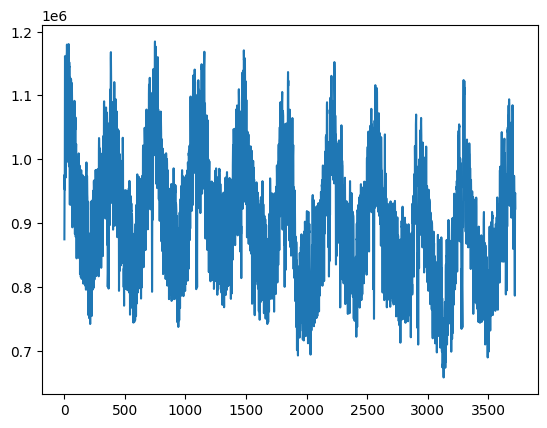

In [ ]:
plt.plot(df2)

### Normalisation de nos données (la target)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
df2_scaled = scaler.fit_transform(np.array(df2).reshape(-1, 1))
df2_scaled

array([[0.41113075],
       [0.56641878],
       [0.60343768],
       ...,
       [0.54329476],
       [0.54908852],
       [0.50266012]])

In [ ]:
df2_scaled.shape

(3725, 1)

## Division de nos données en Trainset et Testset

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#trainset, testset = train_test_split(df2_scaled, test_size=0.2, random_state=0)

In [ ]:
#trainset.shape

In [ ]:
#testset.shape

In [ ]:
training_size = int(len(df2_scaled) * 0.65)
test_size = len(df2_scaled) - training_size
trainset, testset = df2_scaled[0:training_size, :], df2_scaled[training_size:len(df2_scaled), :1]

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

In [ ]:
class TimeSeriesDataset(Dataset):
  def __init__(self, data, seq_len=100):
    self.data = data
    self.data = torch.from_numpy(self.data).float().view(-1)
    self.seq_len = seq_len

  def __len__(self):
    return len(self.data) - self.seq_len -1

  def __getitem__(self, index):
    return self.data[index:index+self.seq_len], self.data[index+self.seq_len]

train_dataset = TimeSeriesDataset(trainset)
test_dataset = TimeSeriesDataset(testset)

In [ ]:
train_dataset, test_dataset

(<__main__.TimeSeriesDataset at 0x7c290d39d190>,
 <__main__.TimeSeriesDataset at 0x7c290d37eb50>)

### Définition du batch size et DataLoaders

In [ ]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size, drop_last=True)

In [ ]:
# utilisation du GPU pour l'entrainement
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Création de notre modèle

In [ ]:
import torch.nn as nn

In [ ]:
class MyLSMTModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MyLSMTModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers) #batch_first=True
        self.fcl = nn.Linear(hidden_size, output_size)

    def forward(self, x, hn_s, cn_s):
        # x est de forme (batch_size, sequence_length, input_size)
        out, (hn_s, cn_s) = self.lstm(x, (hn_s, cn_s))
        # on prend la dernière sortie de la séquence
        final_out = self.fcl(out[-1])
        return final_out, hn_s, cn_s

    def predict(self, x):
        hn_s, cn_s = self.init(batch_size)
        out, _, _ = self.lstm(x, (hn_s, cn_s))
        final_out = self.fcl(out[:, -1, :])
        return final_out

    def init(self):
        # initialisation des états caché et cellule en fonction du batch_size
        h_s0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c_s0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return h_s0, c_s0


# Paramètres du modèle
input_size = 1
hidden_size = 50
num_layers = 3
output_size = 1

model = MyLSMTModel(input_size, hidden_size, num_layers, output_size).to(device)

In [ ]:
model

MyLSMTModel(
  (lstm): LSTM(1, 50, num_layers=3)
  (fcl): Linear(in_features=50, out_features=1, bias=True)
)

## Définition de notre fonction de perte Log Loss

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_epoch_loss = []
test_epoch_loss = []

## Définition de la fonction d'entrainement

In [ ]:
def train(dataloader):
  hn_s, cn_s = model.init()
  model.train()
  epoch_loss = 0
  for batch, item in enumerate(dataloader):
    x, y = item
    x = x.to(device)
    y = y.to(device)
    out, hn_s, cn_s = model(x.reshape(100, batch_size, 1), hn_s, cn_s)
    loss = loss_fn(out.reshape(batch_size), y)
    hn_s = hn_s.detach()
    cn_s = cn_s.detach()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()

  avg_loss = epoch_loss / len(dataloader)
  train_epoch_loss.append(avg_loss)
  print(f"Train loss (avg): {avg_loss:>7f}")

### Dééfinition de la fonction de test

In [ ]:
def test(data_loader):
  hn_s, cn_s = model.init()
  model.eval()
  epoch_loss = 0
  with torch.no_grad():
    for batch, item in enumerate(data_loader):
      x, y = item
      x = x.to(device)
      y = y.to(device)
      out, hn_s, cn_s = model(x.reshape(100, batch_size, 1), hn_s, cn_s)
      loss = loss_fn(out.reshape(batch_size), y)
      epoch_loss += loss.item()

    avg_loss = epoch_loss / len(data_loader)
    test_epoch_loss.append(avg_loss)
    print(f"Test loss (avg): {avg_loss:>7f}")

### Lancement du modèle LSTM sur 30 epoques

In [ ]:
epochs = 35
for epoch in range(epochs):
    print(f"Epoch {epoch}")
    train(train_dataloader)
    test(test_dataloader)
print("Done!")

Epoch 0
Train loss (avg): 0.085335
Test loss (avg): 0.031345
Epoch 1
Train loss (avg): 0.036948
Test loss (avg): 0.029822
Epoch 2
Train loss (avg): 0.037382
Test loss (avg): 0.029603
Epoch 3
Train loss (avg): 0.037733
Test loss (avg): 0.029424
Epoch 4
Train loss (avg): 0.037688
Test loss (avg): 0.029400
Epoch 5
Train loss (avg): 0.037392
Test loss (avg): 0.029545
Epoch 6
Train loss (avg): 0.036956
Test loss (avg): 0.029756
Epoch 7
Train loss (avg): 0.036489
Test loss (avg): 0.029925
Epoch 8
Train loss (avg): 0.036043
Test loss (avg): 0.029985
Epoch 9
Train loss (avg): 0.035613
Test loss (avg): 0.029895
Epoch 10
Train loss (avg): 0.035162
Test loss (avg): 0.029606
Epoch 11
Train loss (avg): 0.034616
Test loss (avg): 0.029051
Epoch 12
Train loss (avg): 0.033785
Test loss (avg): 0.028247
Epoch 13
Train loss (avg): 0.032571
Test loss (avg): 0.027724
Epoch 14
Train loss (avg): 0.032072
Test loss (avg): 0.027007
Epoch 15
Train loss (avg): 0.029479
Test loss (avg): 0.026617
Epoch 16
Train los

## Calcul de la métrique de validation RMSE

In [ ]:
import math
from sklearn.metrics import mean_squared_error

def calculate_metrics(dataloader):
  predicts = []
  y_array = []
  with torch.no_grad():
    hn_s, cn_s = model.init()
    for batch, item in enumerate(dataloader):
      x, y = item
      x = x.to(device)
      y = y.to(device)
      x = x.view(100, batch_size, 1)
      pred = model(x, hn_s, cn_s)[0]
      pred = scaler.inverse_transform(pred.detach().cpu().numpy()).reshape(-1)
      y = scaler.inverse_transform(y.detach().cpu().numpy().reshape(1,-1)).reshape(-1)
      predicts = predicts + pred.tolist()
      y_array = y_array + y.tolist()
    return math.sqrt(mean_squared_error(y_array, predicts)) , y_array, torch.tensor(predicts)

In [ ]:
print(f'train rmse loss : {calculate_metrics(train_dataloader)}')
print(f'test rmse loss : {calculate_metrics(test_dataloader)}')

train rmse loss : (36662.16881765975, [900819.3125, 844763.75, 990705.125, 987226.1875, 973842.4375, 979449.9375, 978086.5625, 888416.1875, 855177.75, 989957.25, 1001373.5625, 981256.0, 994423.0, 979544.25, 890963.4375, 861205.0, 979521.625, 996029.1875, 1009209.0625, 1007651.1875, 859510.25, 866029.875, 845181.125, 968378.875, 976864.5625, 976731.5625, 989977.625, 977989.0625, 868353.1875, 820187.875, 953605.125, 966840.8125, 962438.5625, 834242.375, 873705.1875, 866697.5, 815352.4375, 951296.75, 978917.9375, 982858.5, 976672.25, 971875.375, 869594.4375, 812626.3125, 817458.25, 947922.25, 966767.4375, 955768.3125, 963633.25, 862282.8125, 831161.5625, 948954.0625, 968390.6875, 974589.0, 969678.5625, 966966.6875, 848869.5, 805012.4375, 938446.3125, 953705.3125, 959913.4375, 972486.5, 971896.125, 849544.1875, 810531.625, 937544.5625, 955729.4375, 957631.25, 950474.375, 933821.625, 837767.875, 802208.5625, 945972.1875, 953378.4375, 956539.3125, 956415.75, 947202.5625, 825281.625, 795671.5

In [ ]:
mean_squared_error, y_test, test_outputs = calculate_metrics(test_dataloader)

### Evaluation du modèle

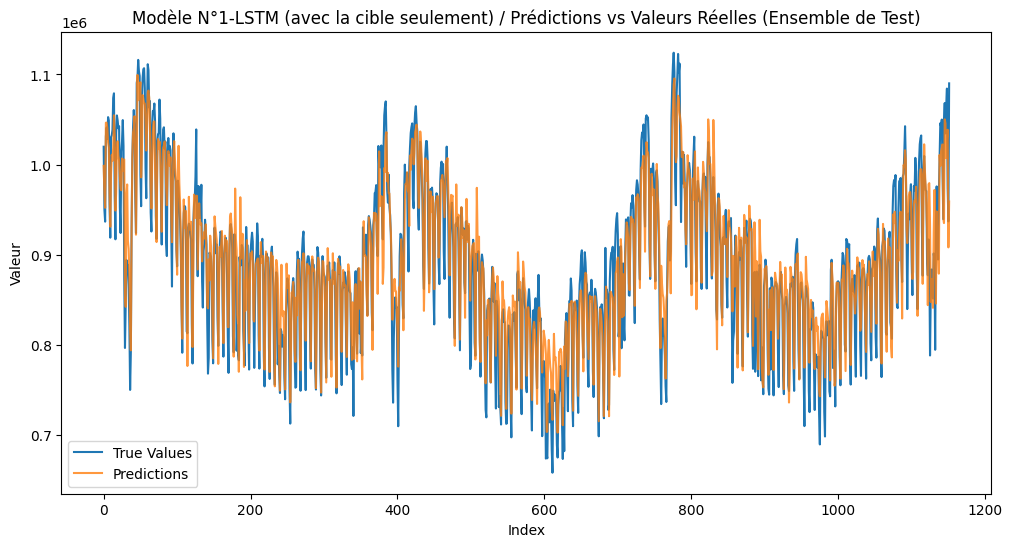

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("Modèle N°1-LSTM (avec la cible seulement) / Prédictions vs Valeurs Réelles (Ensemble de Test)")
plt.xlabel("Index")
plt.ylabel("Valeur")
plt.plot(y_test, label='True Values', )
plt.plot(test_outputs.numpy(), label='Predictions',alpha=0.8)
plt.legend()
plt.show()

### Evaluation de la perte

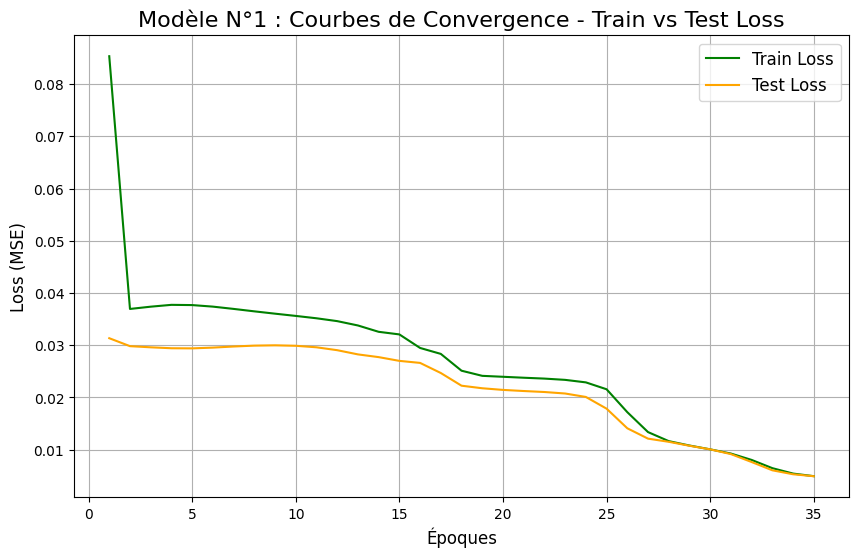

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_epoch_loss) + 1), train_epoch_loss, label="Train Loss", color="green",)
plt.plot(range(1, len(test_epoch_loss) + 1), test_epoch_loss, label="Test Loss", color="orange")
plt.title("Modèle N°1 : Courbes de Convergence - Train vs Test Loss", fontsize=16)
plt.xlabel("Époques", fontsize=12)
plt.ylabel("Loss (MSE)", fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

### Modèle n°2 : LSMT avec plus de features (multivariate Time Series)

#### Features Enginnering
##### Features (1-7) -- Ajout décalage temporelles (lags 1 - 7)

In [ ]:
from pyspark.sql.functions import lag
from pyspark.sql.window import Window

# définir une fenêtre ordonnée par date
window_spec = Window.orderBy('Date')

# ajouter des lags (1 jour, 7 jours)
df1 = df1.withColumn('consommation-1', lag('Daily Total Load', 1).over(window_spec)) \
.withColumn('consommation-2', lag('Daily Total Load', 2).over(window_spec)) \
.withColumn('consommation-3', lag('Daily Total Load', 3).over(window_spec)) \
.withColumn('consommation-4', lag('Daily Total Load', 4).over(window_spec)) \
.withColumn('consommation-5', lag('Daily Total Load', 5).over(window_spec)) \
.withColumn('consommation-6', lag('Daily Total Load', 6).over(window_spec)) \
.withColumn('consommation-7', lag('Daily Total Load', 7).over(window_spec))

df1.show()

+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|      Date|  Daily Total Load|    consommation-1|    consommation-2|    consommation-3|    consommation-4|    consommation-5|    consommation-6|    consommation-7|
+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|2015-01-01|         874540.49|              NULL|              NULL|              NULL|              NULL|              NULL|              NULL|              NULL|
|2015-01-02| 956299.8800000001|         874540.49|              NULL|              NULL|              NULL|              NULL|              NULL|              NULL|
|2015-01-03| 975790.3900000002| 956299.8800000001|         874540.49|              NULL|              NULL|              NULL|              NULL|              NULL|
|2015-01-0

### Feature 8 -- moyennes mobiles (fenêtres glissantes)

Cette variable a pour objectif de connaitre la moyenne de consommation des 7 derniers jours (max), cela pourra donner une information pertinente pour notre modèle

In [ ]:
from pyspark.sql.functions import mean

# fenêtre de 7 jours glissants (les 6 jours précédents + le jour actuel)
window_spec_7 = Window.orderBy("date").rowsBetween(-6, 0)

# ajout de la moyenne mobile
df1 = df1.withColumn('moyenne-mobile-7', mean('Daily Total Load').over(window_spec_7))

df1.show()

+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|      Date|  Daily Total Load|    consommation-1|    consommation-2|    consommation-3|    consommation-4|    consommation-5|    consommation-6|    consommation-7|  moyenne-mobile-7|
+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|2015-01-01|         874540.49|              NULL|              NULL|              NULL|              NULL|              NULL|              NULL|              NULL|         874540.49|
|2015-01-02| 956299.8800000001|         874540.49|              NULL|              NULL|              NULL|              NULL|              NULL|              NULL|        915420.185|
|2015-01-03| 975790.3900000002| 956299.8800000001|         874540.49|           

### extraction des variables (Feature 9 -- Jour) (Feature 10 mois) (Feature 11 -- saison)

In [ ]:
from pyspark.sql.functions import dayofweek, month, when

# Extraire jour de la semaine et mois
df1 = df1.withColumn("day_of_week", dayofweek("date")) \
       .withColumn("month", month("date"))

df1.show()

+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------+-----+
|      Date|  Daily Total Load|    consommation-1|    consommation-2|    consommation-3|    consommation-4|    consommation-5|    consommation-6|    consommation-7|  moyenne-mobile-7|day_of_week|month|
+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------+-----+
|2015-01-01|         874540.49|              NULL|              NULL|              NULL|              NULL|              NULL|              NULL|              NULL|         874540.49|          5|    1|
|2015-01-02| 956299.8800000001|         874540.49|              NULL|              NULL|              NULL|              NULL|              NULL|              NULL|        915420.185|         

### Elimination des NAN résultantes de l'extraction de features


In [ ]:
# Filtrer les valeurs nulles introduites par les lags
df1 = df1.dropna()

# Vérifier les données finales
df1.show()

+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------+-----+
|      Date|  Daily Total Load|    consommation-1|    consommation-2|    consommation-3|    consommation-4|    consommation-5|    consommation-6|    consommation-7|  moyenne-mobile-7|day_of_week|month|
+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------+-----+
|2015-01-08|        1148466.81|1146576.7699999998|1161558.5199999996|        1111304.43| 952406.5999999994| 975790.3900000002| 956299.8800000001|         874540.49| 1064629.057142857|          5|    1|
|2015-01-09|1118710.1499999997|        1148466.81|1146576.7699999998|1161558.5199999996|        1111304.43| 952406.5999999994| 975790.3900000002| 956299.8800000001|1087830.5242857141|         

In [ ]:
df4 = df1.drop('Date').toPandas()
df4.reset_index(drop=True, inplace=True)
features = df4.drop(columns=['Daily Total Load'])
target = df4['Daily Total Load']
df4

,Daily Total Load,consommation-1,consommation-2,consommation-3,consommation-4,consommation-5,consommation-6,consommation-7,moyenne-mobile-7,day_of_week,month
0,1.148467e+06,1146576.77,1161558.52,1111304.43,952406.60,975790.39,956299.88,874540.49,1.064629e+06,5,1
1,1.118710e+06,1148466.81,1146576.77,1161558.52,1111304.43,952406.60,975790.39,956299.88,1.087831e+06,6,1
2,9.993867e+05,1118710.15,1148466.81,1146576.77,1161558.52,1111304.43,952406.60,975790.39,1.091201e+06,7,1
3,9.711775e+05,999386.73,1118710.15,1148466.81,1146576.77,1161558.52,1111304.43,952406.60,1.093883e+06,1,1
4,1.102102e+06,971177.50,999386.73,1118710.15,1148466.81,1146576.77,1161558.52,1111304.43,1.092568e+06,2,1
...,...,...,...,...,...,...,...,...,...,...,...
3713,7.863409e+05,809375.84,885037.28,918652.81,941332.15,959837.76,973979.80,866940.03,8.963652e+05,1,3
3714,8.969718e+05,786340.90,809375.84,885037.28,918652.81,941332.15,959837.76,973979.80,8.853641e+05,2,3
3715,9.441250e+05,896971.84,786340.90,809375.84,885037.28,918652.81,941332.15,959837.76,8.831194e+05,3,3
3716,9.471755e+05,944125.05,896971.84,786340.90,809375.84,885037.28,918652.81,941332.15,8.839542e+05,4,3


In [ ]:
target

,Daily Total Load
0,1.148467e+06
1,1.118710e+06
2,9.993867e+05
3,9.711775e+05
4,1.102102e+06
...,...
3713,7.863409e+05
3714,8.969718e+05
3715,9.441250e+05
3716,9.471755e+05


### Normalisation pour le modèle N°2 de LSTM



In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler.fit_transform(features)
target_scaled = scaler.fit_transform(target.values.reshape(-1, 1))

In [ ]:
features_scaled

array([[0.92781731, 0.95627259, 0.86082351, ..., 0.84071611, 0.66666667,
        0.        ],
       [0.93140712, 0.92781731, 0.95627259, ..., 0.89547989, 0.83333333,
        0.        ],
       [0.87488941, 0.93140712, 0.92781731, ..., 0.90343643, 1.        ,
        0.        ],
       ...,
       [0.45373527, 0.24361066, 0.2873616 , ..., 0.41228827, 0.33333333,
        0.18181818],
       [0.54329476, 0.45373527, 0.24361066, ..., 0.4142586 , 0.5       ,
        0.18181818],
       [0.54908852, 0.54329476, 0.45373527, ..., 0.41563369, 0.66666667,
        0.18181818]])

### Split

In [ ]:
training_size = int(len(features_scaled) * 0.65)
test_size = len(features_scaled) - training_size

X_train, y_train = features_scaled[0:training_size, :], target_scaled[0:training_size, :]
X_test, y_test = features_scaled[training_size:len(features_scaled), :], target_scaled[training_size:len(features_scaled), :]

In [ ]:
X_train.shape

(2416, 10)

In [ ]:
X_test.shape

(1302, 10)

In [ ]:
# Création des séquences
def create_seqs(features, target, seq_length):
    seqs = []
    labels = []
    for i in range(len(features) - seq_length):
        seq = features[i:i + seq_length]
        label = target[i + seq_length]
        seqs.append(seq)
        labels.append(label)
    return np.array(seqs), np.array(labels)

In [ ]:
train_seqs, train_labels = create_seqs(X_train, y_train, seq_length=100)
test_seqs, test_labels = create_seqs(X_test, y_test, seq_length=100)

In [ ]:
test_labels.shape

(1202, 1)

In [ ]:
import torch
from torch.utils.data import Dataset

class TSDatasetElectricity(Dataset):
    def __init__(self, seqs, labels):
        """
        Args:
            seqs (np.array): Input seqs (features).
            labels (np.array): Corresponding labels (targets).
        """
        self.seqs = torch.tensor(seqs, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        return self.seqs[idx], self.labels[idx]

In [ ]:
train_dataset = TSDatasetElectricity(train_seqs, train_labels)
test_dataset = TSDatasetElectricity(test_seqs, test_labels)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for seqs, labels in test_loader:
    print("Batch of sequences:", seqs.shape)
    print("Batch of labels:", labels.shape)

Batch of sequences: torch.Size([64, 100, 10])
Batch of labels: torch.Size([64, 1])
Batch of sequences: torch.Size([64, 100, 10])
Batch of labels: torch.Size([64, 1])
Batch of sequences: torch.Size([64, 100, 10])
Batch of labels: torch.Size([64, 1])
Batch of sequences: torch.Size([64, 100, 10])
Batch of labels: torch.Size([64, 1])
Batch of sequences: torch.Size([64, 100, 10])
Batch of labels: torch.Size([64, 1])
Batch of sequences: torch.Size([64, 100, 10])
Batch of labels: torch.Size([64, 1])
Batch of sequences: torch.Size([64, 100, 10])
Batch of labels: torch.Size([64, 1])
Batch of sequences: torch.Size([64, 100, 10])
Batch of labels: torch.Size([64, 1])
Batch of sequences: torch.Size([64, 100, 10])
Batch of labels: torch.Size([64, 1])
Batch of sequences: torch.Size([64, 100, 10])
Batch of labels: torch.Size([64, 1])
Batch of sequences: torch.Size([64, 100, 10])
Batch of labels: torch.Size([64, 1])
Batch of sequences: torch.Size([64, 100, 10])
Batch of labels: torch.Size([64, 1])
Batc

In [ ]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fcl = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_s0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_s0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_s0, c_s0))  # LSTM output
        out = self.fcl(out[:, -1, :])  # Fully connected layer (using the last time step)
        return out

In [ ]:
# Fonction d'entraînement
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    for seqs, labels in train_loader:
        seqs, labels = seqs.to(device), labels.to(device)

        # Forward pass
        outputs = model(seqs)
        loss = criterion(outputs, labels)

        # Backward pass and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    return epoch_loss / len(train_loader)

In [ ]:
# Fonction de test
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    predics= []
    actuals = []

    with torch.no_grad():
        for seqs, labels in test_loader:
            seqs, labels = seqs.to(device), labels.to(device)

            # Forward pass
            outputs = model(seqs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            predics.extend(outputs.cpu().numpy())  # Récupérer les prédictions
            actuals.extend(labels.cpu().numpy())      # Récupérer les valeurs réelles

    avg_loss = test_loss / len(test_loader)
    return avg_loss, predics, actuals

In [ ]:
input_size = 10  # nb de features
hidden_size = 50  # nb d'unité caché dans LSTM
output_size = 1  # valeur de sortie (e.g., regression)
num_layers = 3

num_epochs = 35
learning_rate = 0.001

# utilisation du GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialisation du modèle, de la fonction de perte et de l'optimiseur
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Entraînement et test
train_loss = []
test_loss = []

for epoch in range(num_epochs):
    # Entraînement du modèle
    train_loss_model = train_model(model, train_loader, criterion, optimizer, device)
    train_loss.append(train_loss_model)

    # Test du modele
    test_loss_model, predicts, actuals = test_model(model, test_loader, criterion, device)
    test_loss.append(test_loss_model)

    print(f"Epoch [{epoch+1}/{num_epochs}] -> Train Loss: {train_loss_model:.4f}, Test Loss: {test_loss_model:.4f}")

# performance final
print(f"Final Test Loss: {test_loss_model:.4f}")

Epoch [1/35] -> Train Loss: 0.0513, Test Loss: 0.0348
Epoch [2/35] -> Train Loss: 0.0215, Test Loss: 0.0189
Epoch [3/35] -> Train Loss: 0.0185, Test Loss: 0.0182
Epoch [4/35] -> Train Loss: 0.0175, Test Loss: 0.0162
Epoch [5/35] -> Train Loss: 0.0170, Test Loss: 0.0175
Epoch [6/35] -> Train Loss: 0.0138, Test Loss: 0.0103
Epoch [7/35] -> Train Loss: 0.0092, Test Loss: 0.0081
Epoch [8/35] -> Train Loss: 0.0079, Test Loss: 0.0076
Epoch [9/35] -> Train Loss: 0.0075, Test Loss: 0.0087
Epoch [10/35] -> Train Loss: 0.0069, Test Loss: 0.0068
Epoch [11/35] -> Train Loss: 0.0064, Test Loss: 0.0065
Epoch [12/35] -> Train Loss: 0.0060, Test Loss: 0.0056
Epoch [13/35] -> Train Loss: 0.0053, Test Loss: 0.0065
Epoch [14/35] -> Train Loss: 0.0050, Test Loss: 0.0055
Epoch [15/35] -> Train Loss: 0.0048, Test Loss: 0.0056
Epoch [16/35] -> Train Loss: 0.0047, Test Loss: 0.0049
Epoch [17/35] -> Train Loss: 0.0045, Test Loss: 0.0050
Epoch [18/35] -> Train Loss: 0.0048, Test Loss: 0.0050
Epoch [19/35] -> Tr

In [ ]:
import math
from sklearn.metrics import mean_squared_error

def calculate_rmse(model, test_loader, scaler, device):
    model.eval()
    predicts = []
    actuals = []

    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            predicts.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    # Dénormaliser les valeurs
    predicts = scaler.inverse_transform(predicts)
    actuals = scaler.inverse_transform(actuals)

    # Calculer le MSE
    mse = mean_squared_error(actuals, predicts)
    # Retourner la RMSE
    rmse = math.sqrt(mse)
    return rmse

# Utilisation de la fonction pour calculer la RMSE réelle
rmse = calculate_rmse(model, test_loader, scaler, device)
print(f"Test RMSE: {rmse:.4f}")


Test RMSE: 34069.2754


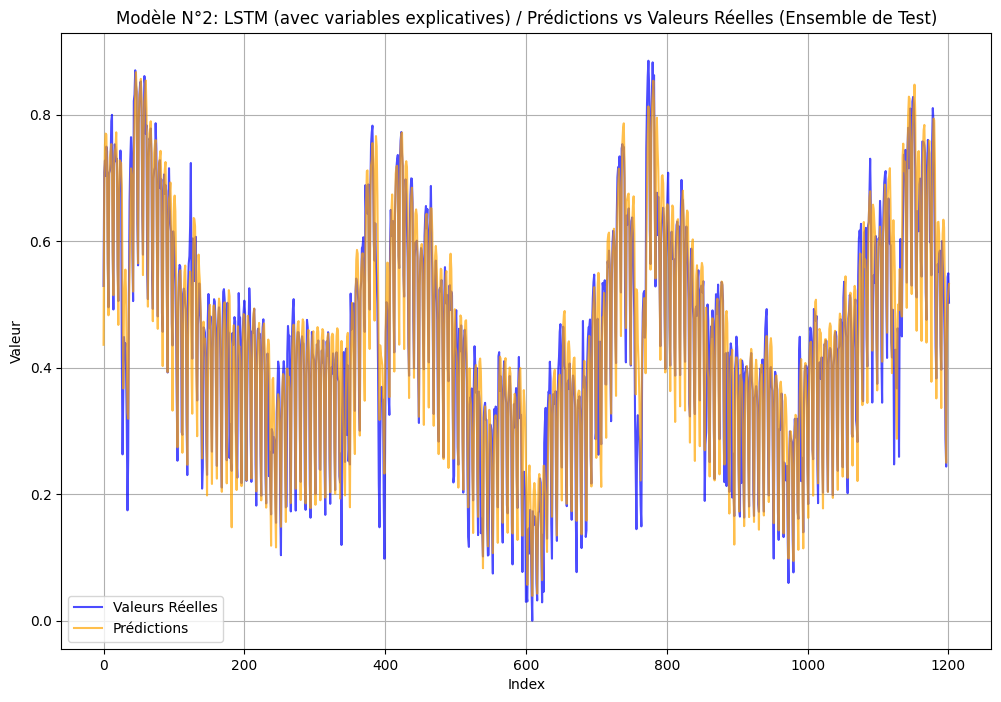

In [ ]:
# Tracé complet des prédictions vs valeurs réelles
def plot_all_predicts(predicts, actuals):
    plt.figure(figsize=(12, 8))
    plt.plot(actuals, label="Valeurs Réelles", color="blue", alpha=0.7)
    plt.plot(predicts, label="Prédictions", color="orange", alpha=0.7)
    plt.xlabel("Index")
    plt.ylabel("Valeur")
    plt.title("Modèle N°2: LSTM (avec variables explicatives) / Prédictions vs Valeurs Réelles (Ensemble de Test)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Appeler la fonction pour tracer toutes les données
plot_all_predicts(predicts, actuals)

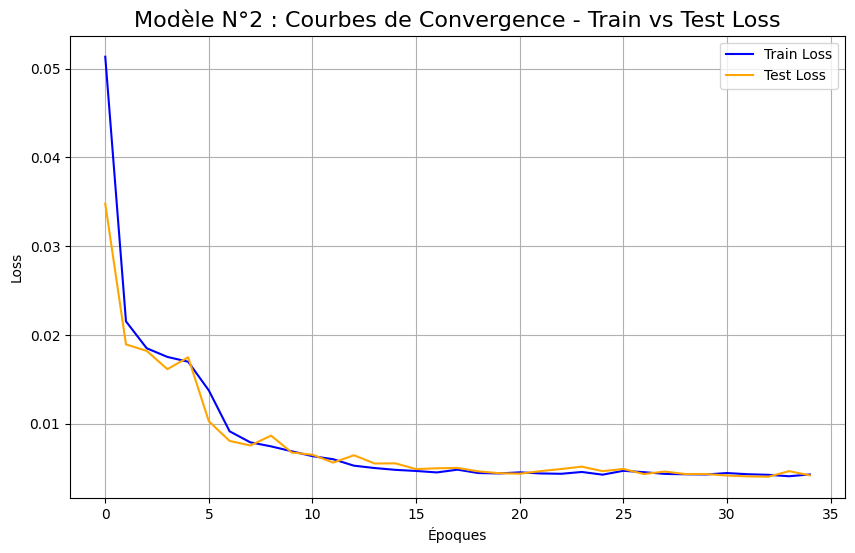

In [ ]:
# Tracé des pertes
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Train Loss", color="blue")
plt.plot(test_loss, label="Test Loss", color="orange")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.title("Modèle N°2 : Courbes de Convergence - Train vs Test Loss", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

###Modèle Avec SPARK (Regression)

In [ ]:
df5 = df1
df5.show()

+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------+-----+
|      Date|  Daily Total Load|    consommation-1|    consommation-2|    consommation-3|    consommation-4|    consommation-5|    consommation-6|    consommation-7|  moyenne-mobile-7|day_of_week|month|
+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------+-----+
|2015-01-08|        1148466.81|1146576.7699999998|1161558.5199999996|        1111304.43| 952406.5999999994| 975790.3900000002| 956299.8800000001|         874540.49| 1064629.057142857|          5|    1|
|2015-01-09|1118710.1499999997|        1148466.81|1146576.7699999998|1161558.5199999996|        1111304.43| 952406.5999999994| 975790.3900000002| 956299.8800000001|1087830.5242857141|         

In [ ]:
# Diviser les données
train_data, test_data = df5.randomSplit([0.75, 0.25], seed=42)

### Normalisation avec Spark

In [ ]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline

# Remove the parentheses from the column names
features_columns=["consommation-1", "consommation-2", "consommation-3", "consommation-4", "consommation-5", "consommation-6", "consommation-7", "moyenne-mobile-7", "day_of_week", "month"]
assembler = VectorAssembler(inputCols=features_columns, outputCol="features")
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

pipeline = Pipeline(stages=[assembler, scaler])

train_data = pipeline.fit(train_data).transform(train_data)
test_data = pipeline.fit(test_data).transform(test_data)

In [ ]:
test_data.select("scaled_features").show()

+--------------------+
|     scaled_features|
+--------------------+
|[0.87797220317462...|
|[0.86095752080713...|
|[0.89139585915867...|
|[0.86546812419068...|
|[0.96724696106440...|
|[0.85740608710290...|
|[0.91070916807487...|
|[1.0,0.9728381229...|
|[0.97894323091072...|
|[0.62176043269565...|
|[0.94390124144277...|
|[0.92921620811729...|
|[0.89561835421822...|
|[0.66004562537920...|
|[0.56783220207866...|
|[0.81191982531828...|
|[0.89080115934473...|
|[0.80453483291840...|
|[0.87957711859093...|
|[0.76976373241470...|
+--------------------+
only showing top 20 rows



In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

LinearRegression = LinearRegression(featuresCol="scaled_features", labelCol="Daily Total Load", regParam=0.1, solver="auto", predictionCol="prediction")

model = LinearRegression.fit(train_data)

predicts = model.transform(test_data)

In [ ]:
# Initialiser l'évaluateur
evaluator = RegressionEvaluator(labelCol="Daily Total Load", predictionCol="prediction", metricName="rmse")

# Calculer le RMSE
rmse = evaluator.evaluate(predicts)
print(f"Root Mean Squared Error (RMSE) : {rmse}")

Root Mean Squared Error (RMSE) : 24827.562401854226


In [ ]:
# Sélectionner les colonnes nécessaires
predicted_data = predicts.select("Daily Total Load", "prediction")

# Afficher les données
predicted_data.show()

+------------------+------------------+
|  Daily Total Load|        prediction|
+------------------+------------------+
| 999386.7300000001| 998466.8886721265|
|1127792.3299999998|1117065.4479283576|
|1112378.0000000002|  1103125.41472742|
|1026343.5900000001|1024744.7793676979|
|1166590.4199999997| 1158315.853895333|
|1116373.5299999998|1103268.1397181808|
|1038381.9300000004| 1035873.366883595|
|1169842.5599999996|1165177.5624837617|
|        1057376.73|1058999.7482484183|
|1128415.5300000003|1125380.3128678794|
|1144660.4600000007|1135480.1303744644|
|1144982.8100000003|1141675.4735401848|
|1120589.7999999998|1113245.1707252546|
|         961653.16| 955585.7747798116|
|        1085260.78|1077215.8526038674|
|1111334.0399999996|1093738.2717512911|
|1113892.4499999997|1106287.7475724162|
| 991685.6900000001| 988526.1226666983|
|1115567.7199999997|1100068.3228073285|
|        1069157.34| 1051470.128747859|
+------------------+------------------+
only showing top 20 rows



In [ ]:
# Convertir le Spark DataFrame en Pandas DataFrame
predicted_data_pd = predicted_data.toPandas()

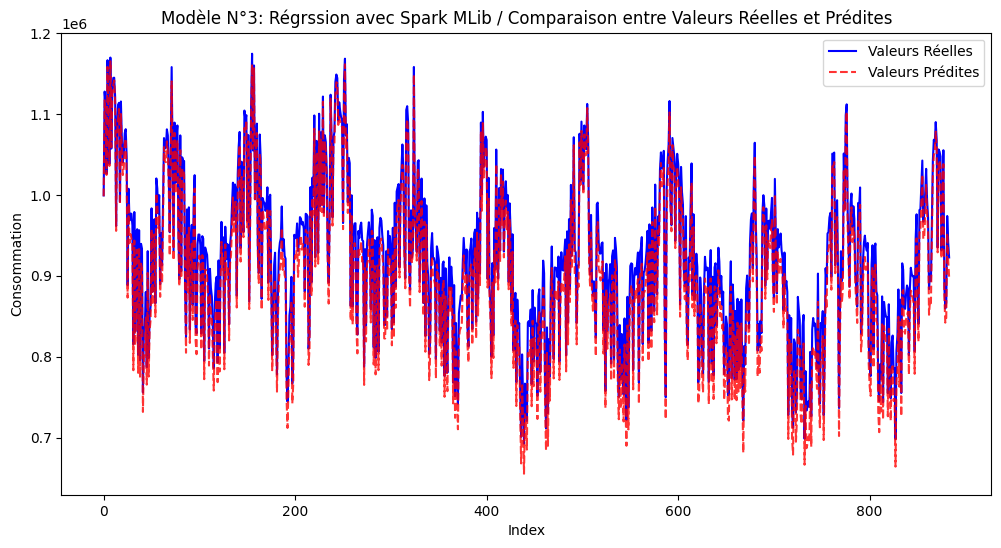

In [ ]:
# Tracer les valeurs réelles et prédites
plt.figure(figsize=(12, 6))
plt.plot(predicted_data_pd["Daily Total Load"], label="Valeurs Réelles", color="blue")
plt.plot(predicted_data_pd["prediction"], label="Valeurs Prédites", color="red", linestyle="dashed", alpha=0.8)

# Ajouter des légendes et des titres
plt.title("Modèle N°3: Régrssion avec Spark MLib / Comparaison entre Valeurs Réelles et Prédites")
plt.xlabel("Index")
plt.ylabel("Consommation")
plt.legend()
plt.show()

## Visualisation de l'erreur résiduelle

In [ ]:
residuals = predicts.withColumn("residual", predicts["Daily Total Load"] - predicts["prediction"])
residuals.describe('residual').show()

+-------+-------------------+
|summary|           residual|
+-------+-------------------+
|  count|                884|
|   mean| 23291.867656673865|
| stddev|  8601.188532244509|
|    min|-2364.7903556113597|
|    max|  46429.03982244013|
+-------+-------------------+



In [ ]:
residuals_pd = residuals.select("residual").toPandas()
residuals_pd.head()

,residual
0,919.841328
1,10726.882072
2,9252.585273
3,1598.810632
4,8274.566105


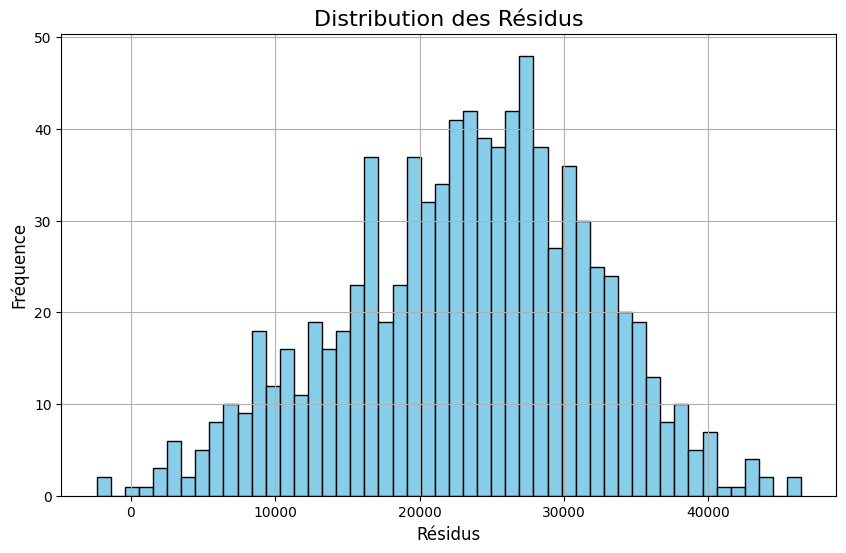

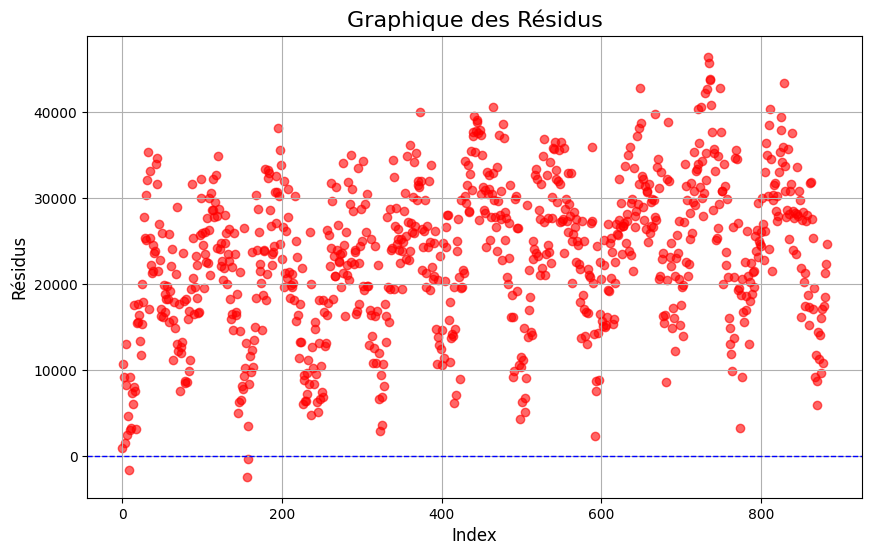

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(residuals_pd["residual"], bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution des Résidus", fontsize=16)
plt.xlabel("Résidus", fontsize=12)
plt.ylabel("Fréquence", fontsize=12)
plt.grid(True)
plt.show()

# Graphique de dispersion des résidus
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals_pd)), residuals_pd["residual"], alpha=0.6, color="red")
plt.axhline(y=0, color="blue", linestyle="--", linewidth=1)
plt.title("Graphique des Résidus", fontsize=16)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Résidus", fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import pyspark.sql.functions as F

In [ ]:
# Création du modèle de régression linéaire
lr = LinearRegression(featuresCol="scaled_features", labelCol="Daily Total Load", solver="auto")

# Paramètres à tester
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01, 0.001])\
    .addGrid(lr.maxIter, [10, 50, 100])\
    .build()

# Configuration du TrainValidationSplit pour la validation croisée
tvs = TrainValidationSplit(
    estimator=lr,
    estimatorParamMaps=paramGrid,
    evaluator=RegressionEvaluator(labelCol="Daily Total Load", predictionCol="prediction", metricName="rmse"),
    trainRatio=0.8
)

# Entraînement du modèle sur les données d'entraînement
model1 = tvs.fit(train_data)

# Récupérer le meilleur modèle
bestModel = model1.bestModel

# Faire des prédictions sur les données de test
predictions = bestModel.transform(test_data)
predictions.select("scaled_features", "Daily Total Load", "prediction").show()

# Évaluer le modèle : calcul du RMSE
rmse = RegressionEvaluator(labelCol="Daily Total Load", predictionCol="prediction", metricName="rmse").evaluate(predictions)

# Calcul de la consommation moyenne réelle sur le jeu de test
mean_val = predictions.select(F.mean("Daily Total Load")).collect()[0][0]

# Calcul du RMSE en pourcentage
rmse_percentage = (rmse / mean_val) * 100

print(f"Root Mean Squared Error (RMSE) sur test data = {rmse:.2f}")
print(f"Pourcentage RMSE de la consommation journalière moyenne = {rmse_percentage:.2f}%")


+--------------------+------------------+------------------+
|     scaled_features|  Daily Total Load|        prediction|
+--------------------+------------------+------------------+
|[0.87797220317462...| 999386.7300000001| 998465.5612434138|
|[0.86095752080713...|1127792.3299999998|1117066.8019137399|
|[0.89139585915867...|1112378.0000000002|1103123.7753066595|
|[0.86546812419068...|1026343.5900000001|1024745.9647544426|
|[0.96724696106440...|1166590.4199999997| 1158322.309130991|
|[0.85740608710290...|1116373.5299999998|1103255.2063857247|
|[0.91070916807487...|1038381.9300000004|1035864.9271853779|
|[1.0,0.9728381229...|1169842.5599999996|1165180.9137284993|
|[0.97894323091072...|        1057376.73| 1058997.887095919|
|[0.62176043269565...|1128415.5300000003|1125393.5916588309|
|[0.94390124144277...|1144660.4600000007|1135479.2225442312|
|[0.92921620811729...|1144982.8100000003|1141669.3311850617|
|[0.89561835421822...|1120589.7999999998| 1113237.070213877|
|[0.66004562537920...|  